# Binary hypothesis testing

This notebook builds upon the mixture model estimation technique to implement different binary classifiers

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread,imsave   # image processing
from scipy.optimize import curve_fit
from scipy.stats import *       # stats utils

from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
# print rcParams['font.size']

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

import utils

Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002
RX gain: 20.0 dB


In [3]:
test_image_list = sorted(glob('../data/test/*.png')) # window set to 2.25m to 11.25m
test_config_list = sorted(glob('../data/test/*.json'))
print len(test_image_list),'image files,', len(test_config_list),'config files'

for i in range(0,len(test_image_list)):
    print(test_image_list[i])
    print(test_config_list[i])
    print(' ')

10 image files, 10 config files
../data/test/1468966347175925.png
../data/test/1468966347175925.json
 
../data/test/1468966376377511.png
../data/test/1468966376377511.json
 
../data/test/1468966376476216.png
../data/test/1468966376476216.json
 
../data/test/1468966851909797.png
../data/test/1468966851909797.json
 
../data/test/1468969086135548.png
../data/test/1468969086135548.json
 
../data/test/1468970074505798.png
../data/test/1468970074505798.json
 
../data/test/1468970271148135.png
../data/test/1468970271148135.json
 
../data/test/1468970485675274.png
../data/test/1468970485675274.json
 
../data/test/1468970745714629.png
../data/test/1468970745714629.json
 
../data/test/1468970832506128.png
../data/test/1468970832506128.json
 


## ROC curves


0 t= 44 , epsilon= 0.172549019608 , p_fa= [  9.7732e-06] , p_d= [ 0.4126]
0 t=0.22 , p_fa= 6.22333996336e-07 , p_d= 0.239954690573

1 t= 62 , epsilon= 0.243137254902 , p_fa= [  9.4975e-06] , p_d= [ 0.2599]
1 t=0.22 , p_fa= 2.55230894153e-05 , p_d= 0.332498972079

2 t= 57 , epsilon= 0.223529411765 , p_fa= [  8.5330e-06] , p_d= [ 0.2394]
2 t=0.22 , p_fa= 1.02200416636e-05 , p_d= 0.251484654227

3 t= 66 , epsilon= 0.258823529412 , p_fa= [  9.6261e-06] , p_d= [ 0.1665]
3 t=0.22 , p_fa= 4.50567558402e-05 , p_d= 0.274170798591

4 t= 52 , epsilon= 0.203921568627 , p_fa= [  8.2210e-06] , p_d= [ 0.5045]
4 t=0.22 , p_fa= 3.71923553788e-06 , p_d= 0.452794427061

5 t= 35 , epsilon= 0.137254901961 , p_fa= [  9.0700e-06] , p_d= [ 0.3869]
5 t=0.22 , p_fa= 2.10961865754e-08 , p_d= 0.0902067843669

6 t= 49 , epsilon= 0.192156862745 , p_fa= [  9.6913e-06] , p_d= [ 0.9527]
6 t=0.22 , p_fa= 2.26608612741e-06 , p_d= 0.938563720522

7 t= 97 , epsilon= 0.380392156863 , p_fa= [  9.4276e-06] , p_d= [ 0.0425]


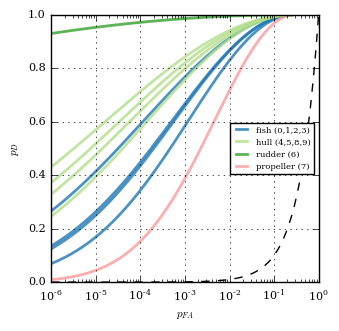

In [21]:
# ROC curve for intensity threshold decision rule
plt.figure(figsize=(3.45,3.45))
# indices = (0,1,5,6,7)
indices = (0,1,2,3,4,5,6,7,8,9)
# labels  = ('fish','fish','fish','fish','hull','hull','rudder','propeller','hull','hull')
labels  = ('fish (0,1,2,3)','_nolegend_','_nolegend_','_nolegend_','hull (4,5,8,9)','_nolegend_','rudder (6)','propeller (7)','_nolegend_','_nolegend_')

colors  = ('#1f78b4','#1f78b4','#1f78b4','#1f78b4','#b2df8a','#b2df8a','#33a02c','#fb9a99','#b2df8a','#b2df8a')
x = np.linspace(0,1.0,256)

np.set_printoptions(precision=4)

for i in indices:
    idx = i
    image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
    didson.loadConfig(test_config_list[idx])
    didson.noise=0.001
    image_d = didson.deconvolve(image)
    image_d = didson.removeTaper(image_d)
    
    (p,k) = utils.getMixtureParameters(image_d)
    pi1 = p[0]
    pi2 = p[1]
    s1  = p[2]
    s2  = p[3]
    
    p_bg = pi1/(1-pi2)
    pmf_bg = utils.background_pmf(x, p_bg, s1 )
    pmf_o  = utils.object_pmf(x, s2)
    p_fa = 1 - np.cumsum(pmf_bg)
    p_d  = 1 - np.cumsum(pmf_o)
    
    print ''
    kfa = np.argwhere(p_fa<0.00001)[0]
    print idx,'t=',kfa[0],', epsilon=',kfa[0]/255.0, ', p_fa=',p_fa[kfa],', p_d=',p_d[kfa]
    print idx, 't=0.22',  ', p_fa=',p_fa[56],', p_d=',p_d[56]

#     plt.plot(p_fa,p_d,'-',color='#1f78b4',alpha=1.0,linewidth=2.0)
    plt.plot(p_fa,p_d,'-',alpha=0.8,linewidth=2.0,color=colors[i],label=labels[i])

    
eq = np.logspace(-6,0,100)
plt.plot(eq,eq,'--',color='k')

plt.grid()
plt.xlabel('$p_{FA}$')
plt.ylabel('$p_{D}$')
plt.axis('equal')
plt.xlim([1e-6,1])
plt.ylim([1e-6,1])
plt.xscale('log')
# plt.yscale('log')
plt.legend(loc=0,fontsize=6)
rcParams['font.size'] = 8

plt.savefig('roc_5.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!

0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137
0.219607843137


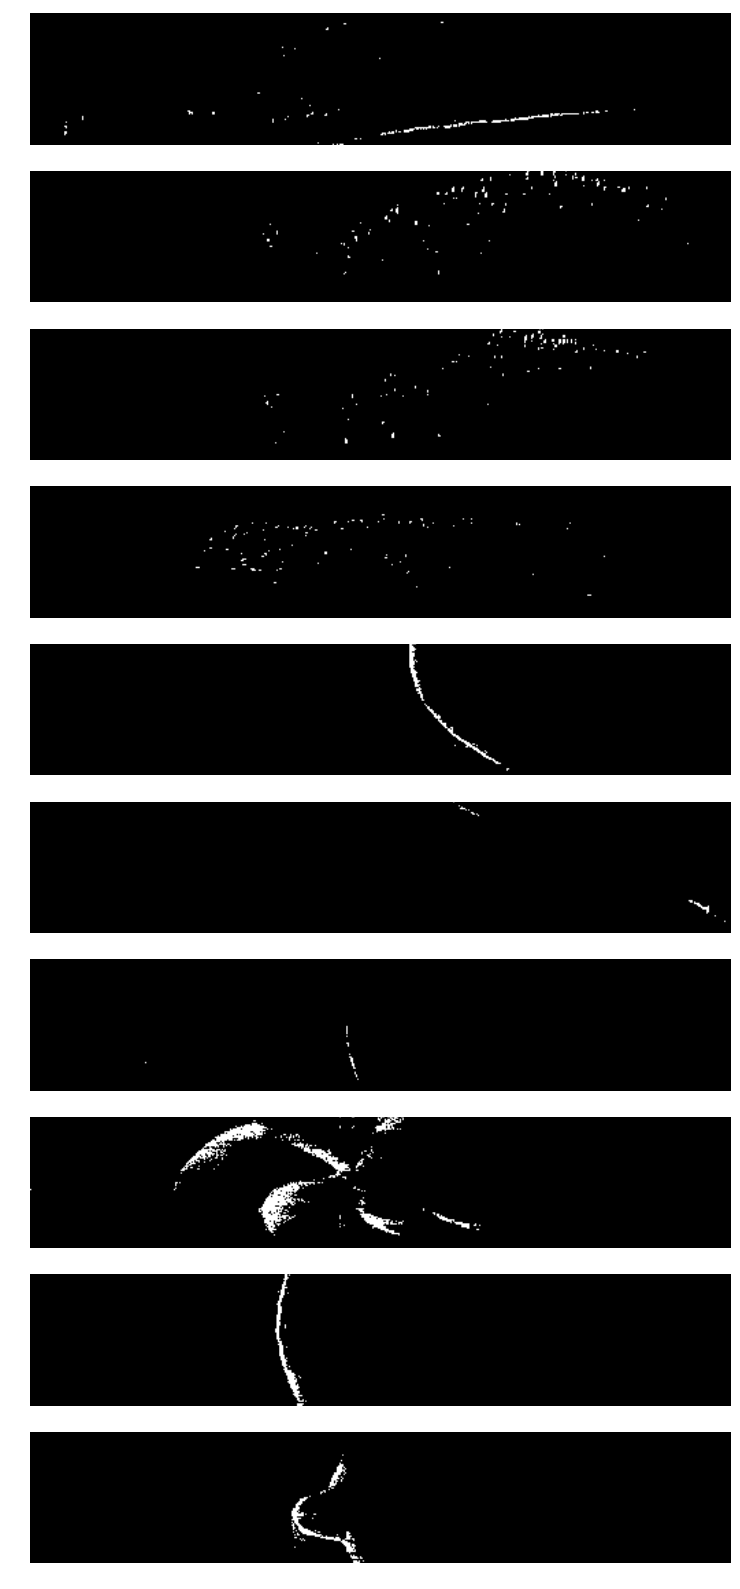

In [20]:
plt.figure(figsize=(20,20))
for idx in range(0,10):
    image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
    didson.loadConfig(test_config_list[idx])
    didson.noise=0.02
    image_d = didson.deconvolve(image)
    image_d = didson.removeTaper(image_d)
    image_b = np.copy(image_d)
    epsilon = 56.0/255.0
#     epsilon = 0.2
    print epsilon
    image_b[image_b<epsilon] = 0.0
    image_b[image_b>epsilon] = 1.0

    plt.subplot(10,1,idx+1)
    plt.imshow(image_b.transpose(),cmap='gray')
    plt.axis('off')
    
    img_out = (255*(1-image_b.transpose()))
    imsave('ft2_'+str(idx)+'.png',img_out.astype(np.uint8))
    
    

In [ ]:
print len(p_fa)
np.sum(pmf_bg)


In [ ]:
isinstance(x,)


## Threshold decision rule

## MAP (_maximum a posteriori_) decision rule

In [ ]:
# likelihood ratio (used in the MAP decision rule)
plt.figure(figsize=(3.45,3.45))
plt.plot(x,pmf_o/pmf_bg)
plt.grid()
plt.xlabel('$y$')
plt.ylabel('$\Lambda(y)$')
plt.yscale('log')
plt.xlim([0,1])

In [ ]:
plt.figure(figsize=(3.45,3.45))
plt.plot(x,p_fa)
plt.plot(x,p_d)
plt.xlim([0,0.2])
plt.grid()
plt.legend(('$p_{FA}$','$p_{D}$'))

print p_fa[25:30]
print p_d[25:30]
print x[28]

## Neyman-Pearson decision rule
